In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
tqdm.pandas()

In [3]:
def get_hop_count(ttl):
    """
    Estimate the hop count based on TTL and common OS initial TTLs.
    """
    if ttl == 0:
        return np.nan
    if ttl >= 240:
        return 255 - ttl
    elif 60 <= ttl <= 70:
        return 64 - ttl
    elif 100 <= ttl <= 130:
        return 128 - ttl
    else:
        return 255 - ttl

def label_reply(reply):
    """
    Create a clear label for the reply type based solely on the reply_type string.
    """
    if reply.startswith("0x0000"):
        return "responsive"
    elif reply.startswith("0x0800"):
        return "no_response"
    elif reply.startswith("0x03"):
        return "error"
    else:
        return "other"

def compute_volatility(group, flag_col, time_col):
    """
    Compute volatility as the number of state transitions (responsive to non-responsive)
    divided by (number of probes - 1). The group is sorted by time.
    """
    group_sorted = group.sort_values(time_col)
    flags = group_sorted[flag_col].values
    if len(flags) < 2:
        return np.nan
    transitions = np.sum(flags[1:] != flags[:-1])
    return transitions / (len(flags) - 1)

def compute_median_up(group, flag_col, time_col):
    """
    Compute median-up as the median duration of consecutive up periods.
    """
    group_sorted = group.sort_values(time_col)
    flags = group_sorted[flag_col].values
    times = group_sorted[time_col].values
    up_durations = []
    current_start = None
    for i, flag in enumerate(flags):
        if flag == 1:
            if current_start is None:
                current_start = times[i]
        else:
            if current_start is not None:
                duration = times[i-1] - current_start
                up_durations.append(duration)
                current_start = None
    if current_start is not None:
        duration = times[-1] - current_start
        up_durations.append(duration)
    if len(up_durations) == 0:
        return 0
    return np.median(up_durations)

In [4]:
def load_and_process(filename, year):
    """
    Load and process raw probe data. The resulting DataFrame will have a year-specific suffix.
    """
    col_names = ['reply_type', 'time_s', 'rtt_us', 'ttl', 'probe_addr', 'reply_addr']
    df = pd.read_csv(filename, sep=r'\s+', names=col_names, engine='python')

    df['time_s'] = pd.to_numeric(df['time_s'], errors='coerce')
    df['rtt_us'] = pd.to_numeric(df['rtt_us'], errors='coerce')
    df['ttl'] = pd.to_numeric(df['ttl'], errors='coerce')
    df = df.dropna(subset=['time_s', 'rtt_us', 'ttl'])

    df['real_time'] = pd.to_datetime(df['time_s'], unit='s')
    df['reply_type_label'] = df['reply_type'].apply(label_reply)
    df['rtt_us'] = df['rtt_us'] / 1000.0
    df['hop_count'] = df['ttl'].apply(get_hop_count)
    df['same_ip'] = df['reply_addr'] == df['probe_addr']

    suffix = f"_{year}"
    df = df.add_suffix(suffix)

    desired_last = [f"same_ip{suffix}", f"reply_type_label{suffix}", f"hop_count{suffix}", f"real_time{suffix}"]
    all_cols = list(df.columns)
    other_cols = [col for col in all_cols if col not in desired_last]
    new_order = other_cols + desired_last
    df = df[new_order]

    return df

In [5]:
df_2013 = load_and_process('filtered_2013.txt', 2013)

In [6]:
df_2013

,reply_type_2013,time_s_2013,rtt_us_2013,ttl_2013,probe_addr_2013,reply_addr_2013,same_ip_2013,reply_type_label_2013,hop_count_2013,real_time_2013
1,0x0000,1.385587e+09,65.523,243.0,128.104.76.50,128.104.76.50,True,responsive,12.0,2013-11-27 21:16:57
2,0x0800,1.385587e+09,0.000,0.0,128.72.108.50,--------,False,no_response,NaN,2013-11-27 21:16:54
3,0x0000,1.385587e+09,68.784,117.0,128.208.244.50,128.208.244.50,True,responsive,11.0,2013-11-27 21:16:59
4,0x0800,1.385587e+09,0.000,0.0,128.240.212.50,--------,False,no_response,NaN,2013-11-27 21:16:54
5,0x0800,1.385587e+09,0.000,0.0,128.152.188.50,--------,False,no_response,NaN,2013-11-27 21:16:55
...,...,...,...,...,...,...,...,...,...,...
16860455,0x0800,1.388370e+09,0.000,0.0,128.147.72.50,--------,False,no_response,NaN,2013-12-30 02:13:56
16860456,0x0800,1.388370e+09,0.000,0.0,128.83.136.50,--------,False,no_response,NaN,2013-12-30 02:13:56
16860457,0x0800,1.388370e+09,0.000,0.0,128.211.8.50,--------,False,no_response,NaN,2013-12-30 02:13:56
16860458,0x0800,1.388370e+09,0.000,0.0,128.47.244.50,--------,False,no_response,NaN,2013-12-30 02:13:56


In [72]:
df_2013.to_csv('df_2013.csv', index=True)

In [73]:
df_2023.to_csv('df_2023.csv', index=True)

In [58]:
null_rows_except_hop_count = df_2023[df_2023.drop(columns='hop_count_2023').isnull().any(axis=1)]
null_rows_except_hop_count

,reply_type_2023,time_s_2023,rtt_us_2023,ttl_2023,probe_addr_2023,reply_addr_2023,same_ip_2023,reply_type_label_2023,hop_count_2023,real_time_2023


In [7]:
df_2023 = load_and_process('filtered_2023.txt', 2023)

In [8]:
df_2023

,reply_type_2023,time_s_2023,rtt_us_2023,ttl_2023,probe_addr_2023,reply_addr_2023,same_ip_2023,reply_type_label_2023,hop_count_2023,real_time_2023
1,0x0800,1.703288e+09,0.0,0.0,128.119.241.156,--------,False,no_response,NaN,2023-12-22 23:32:11
2,0x0800,1.703288e+09,0.0,0.0,128.231.97.156,--------,False,no_response,NaN,2023-12-22 23:32:11
3,0x0800,1.703288e+09,0.0,0.0,128.207.73.156,--------,False,no_response,NaN,2023-12-22 23:32:11
4,0x0800,1.703288e+09,0.0,0.0,128.15.137.156,--------,False,no_response,NaN,2023-12-22 23:32:11
5,0x0800,1.703288e+09,0.0,0.0,128.87.209.156,--------,False,no_response,NaN,2023-12-22 23:32:11
...,...,...,...,...,...,...,...,...,...,...
17338778,0x0800,1.706039e+09,0.0,0.0,128.72.49.156,--------,False,no_response,NaN,2024-01-23 19:47:44
17338779,0x0800,1.706039e+09,0.0,0.0,128.200.177.156,--------,False,no_response,NaN,2024-01-23 19:47:44
17338780,0x0800,1.706039e+09,0.0,0.0,128.40.81.156,--------,False,no_response,NaN,2024-01-23 19:47:44
17338781,0x0800,1.706039e+09,0.0,0.0,128.168.209.156,--------,False,no_response,NaN,2024-01-23 19:47:44


In [9]:
common_probes = set(df_2013['probe_addr_2013']).intersection(set(df_2023['probe_addr_2023']))
len(common_probes)

16711651

In [10]:
df_2013_common = df_2013[df_2013['probe_addr_2013'].isin(common_probes)].copy()

In [11]:
df_2013_common

,reply_type_2013,time_s_2013,rtt_us_2013,ttl_2013,probe_addr_2013,reply_addr_2013,same_ip_2013,reply_type_label_2013,hop_count_2013,real_time_2013
1,0x0000,1.385587e+09,65.523,243.0,128.104.76.50,128.104.76.50,True,responsive,12.0,2013-11-27 21:16:57
2,0x0800,1.385587e+09,0.000,0.0,128.72.108.50,--------,False,no_response,NaN,2013-11-27 21:16:54
3,0x0000,1.385587e+09,68.784,117.0,128.208.244.50,128.208.244.50,True,responsive,11.0,2013-11-27 21:16:59
4,0x0800,1.385587e+09,0.000,0.0,128.240.212.50,--------,False,no_response,NaN,2013-11-27 21:16:54
5,0x0800,1.385587e+09,0.000,0.0,128.152.188.50,--------,False,no_response,NaN,2013-11-27 21:16:55
...,...,...,...,...,...,...,...,...,...,...
16860455,0x0800,1.388370e+09,0.000,0.0,128.147.72.50,--------,False,no_response,NaN,2013-12-30 02:13:56
16860456,0x0800,1.388370e+09,0.000,0.0,128.83.136.50,--------,False,no_response,NaN,2013-12-30 02:13:56
16860457,0x0800,1.388370e+09,0.000,0.0,128.211.8.50,--------,False,no_response,NaN,2013-12-30 02:13:56
16860458,0x0800,1.388370e+09,0.000,0.0,128.47.244.50,--------,False,no_response,NaN,2013-12-30 02:13:56


In [12]:
df_2023_common = df_2023[df_2023['probe_addr_2023'].isin(common_probes)].copy()

In [13]:
df_2023_common

,reply_type_2023,time_s_2023,rtt_us_2023,ttl_2023,probe_addr_2023,reply_addr_2023,same_ip_2023,reply_type_label_2023,hop_count_2023,real_time_2023
1,0x0800,1.703288e+09,0.0,0.0,128.119.241.156,--------,False,no_response,NaN,2023-12-22 23:32:11
2,0x0800,1.703288e+09,0.0,0.0,128.231.97.156,--------,False,no_response,NaN,2023-12-22 23:32:11
3,0x0800,1.703288e+09,0.0,0.0,128.207.73.156,--------,False,no_response,NaN,2023-12-22 23:32:11
4,0x0800,1.703288e+09,0.0,0.0,128.15.137.156,--------,False,no_response,NaN,2023-12-22 23:32:11
5,0x0800,1.703288e+09,0.0,0.0,128.87.209.156,--------,False,no_response,NaN,2023-12-22 23:32:11
...,...,...,...,...,...,...,...,...,...,...
17338778,0x0800,1.706039e+09,0.0,0.0,128.72.49.156,--------,False,no_response,NaN,2024-01-23 19:47:44
17338779,0x0800,1.706039e+09,0.0,0.0,128.200.177.156,--------,False,no_response,NaN,2024-01-23 19:47:44
17338780,0x0800,1.706039e+09,0.0,0.0,128.40.81.156,--------,False,no_response,NaN,2024-01-23 19:47:44
17338781,0x0800,1.706039e+09,0.0,0.0,128.168.209.156,--------,False,no_response,NaN,2024-01-23 19:47:44


In [14]:
duplicates_2013 = df_2013_common['probe_addr_2013'].duplicated().sum()
print("Number of duplicate probe addresses in df_2013_common:", duplicates_2013)

Number of duplicate probe addresses in df_2013_common: 148806


In [15]:
duplicates_2023 = df_2023_common['probe_addr_2023'].duplicated().sum()
print("Number of duplicate probe addresses in df_2023_common:", duplicates_2023)

Number of duplicate probe addresses in df_2023_common: 561568


In [16]:
def compute_ip_metrics_vectorized(group):
    """
    Given a DataFrame 'group' for one probe address, compute key features:
      - availability: fraction of probes that are responsive.
      - mean_rtt: average RTT (in ms) for responsive probes.
      - rtt_std: standard deviation of RTT (in ms) for responsive probes.
      - volatility: (# of up periods) / ceil(total probes / 2)
      - median_up_time: median duration (in seconds) of continuous 'up' periods.
      
    This function automatically detects the correct time and RTT columns (which are suffixed by year).
    It assumes a 'responsive_flag' column is already present.
    
    Uses vectorized NumPy operations to identify contiguous up periods.
    """
    time_col = group.filter(regex="^time_s_").columns[0]
    rtt_col = group.filter(regex="^rtt_us_").columns[0]
    
    group = group.sort_values(time_col)
    times = group[time_col].values
    flags = group['responsive_flag'].values.astype(int)
    n_probes = len(group)
    
    availability = flags.mean()
    
    responsive_rtts = group.loc[group['responsive_flag'] == 1, rtt_col].values
    mean_rtt = responsive_rtts.mean() if responsive_rtts.size > 0 else np.nan
    rtt_std = responsive_rtts.std() if responsive_rtts.size > 0 else np.nan
    
    if flags.size == 0 or np.all(flags == 0):
        up_periods = np.array([])
    else:
        up_indices = np.flatnonzero(flags)
        split_points = np.where(np.diff(up_indices) != 1)[0] + 1
        segments = np.split(up_indices, split_points)
        up_periods = np.array([times[seg[-1]] - times[seg[0]] for seg in segments])
    
    num_up_periods = len(up_periods)
    volatility = num_up_periods / (np.ceil(n_probes / 2.0)) if n_probes > 0 else np.nan
    median_up_time = np.median(up_periods) if up_periods.size > 0 else np.nan
    
    return pd.Series({
        'availability': availability,
        'mean_rtt': mean_rtt,
        'rtt_std': rtt_std,
        'volatility': volatility,
        'median_up_time': median_up_time,
        'n_probes': n_probes,
        'num_up_periods': num_up_periods
    })

In [17]:
df_2013_common = df_2013_common.copy()
df_2013_common['responsive_flag'] = (df_2013_common['reply_type_label_2013'] == 'responsive').astype(int)

In [18]:
features_2013 = df_2013_common.groupby('probe_addr_2013').progress_apply(compute_ip_metrics_vectorized)
features_2013.to_csv('features_2013.csv', index=True)
features_2013

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16711651/16711651 [1:59:56<00:00, 2322.14it/s]


,availability,mean_rtt,rtt_std,volatility,median_up_time,n_probes,num_up_periods
probe_addr_2013,,,,,,,
128.0.0.0,0.0,NaN,NaN,0.0,NaN,2.0,0.0
128.0.0.1,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.0.0.10,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.0.0.100,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.0.0.101,0.0,NaN,NaN,0.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...
128.99.99.95,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.99.99.96,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.99.99.97,0.0,NaN,NaN,0.0,NaN,1.0,0.0


In [19]:
df_2023_common = df_2023_common.copy()
df_2023_common['responsive_flag'] = (df_2023_common['reply_type_label_2023'] == 'responsive').astype(int)

In [20]:
features_2023 = df_2023_common.groupby('probe_addr_2023').progress_apply(compute_ip_metrics_vectorized)
features_2023.to_csv('features_2023.csv', index=True)
features_2023

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16711651/16711651 [2:02:10<00:00, 2279.77it/s]


,availability,mean_rtt,rtt_std,volatility,median_up_time,n_probes,num_up_periods
probe_addr_2023,,,,,,,
128.0.0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.0.0.1,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.0.0.10,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.0.0.100,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.0.0.101,0.0,NaN,NaN,0.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...
128.99.99.95,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.99.99.96,0.0,NaN,NaN,0.0,NaN,1.0,0.0
128.99.99.97,0.0,NaN,NaN,0.0,NaN,1.0,0.0


In [21]:
feature_cols = ['availability', 'mean_rtt', 'rtt_std', 'volatility', 'median_up_time']
X_2013 = features_2013[feature_cols].dropna().values

scaler = StandardScaler()
X_2013_norm = scaler.fit_transform(X_2013)

n_clusters = 4
kmeans_2013 = KMeans(n_clusters=n_clusters, random_state=42)
clusters_2013 = kmeans_2013.fit_predict(X_2013_norm)

features_2013_clean = features_2013.dropna(subset=feature_cols).copy()
features_2013_clean['cluster'] = clusters_2013

print("Cluster counts for 2013:")
print(features_2013_clean['cluster'].value_counts())

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster counts for 2013:
cluster
0    599239
2     14060
3       113
1        32
Name: count, dtype: int64


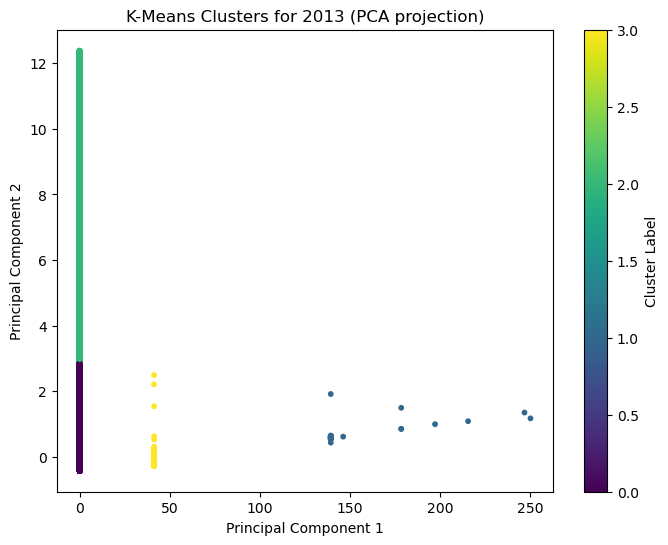

In [22]:
pca = PCA(n_components=2)
X_2013_pca = pca.fit_transform(X_2013_norm)
plt.figure(figsize=(8,6))
plt.scatter(X_2013_pca[:,0], X_2013_pca[:,1], c=clusters_2013, cmap='viridis', s=10)
plt.title('K-Means Clusters for 2013 (PCA projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [23]:
X_2023 = features_2023[feature_cols].dropna().values
X_2023_norm = scaler.fit_transform(X_2023)  # Optionally, use a new scaler or the same parameters if comparing directly.
kmeans_2023 = KMeans(n_clusters=n_clusters, random_state=42)
clusters_2023 = kmeans_2023.fit_predict(X_2023_norm)

features_2023_clean = features_2023.dropna(subset=feature_cols).copy()
features_2023_clean['cluster'] = clusters_2023

print("Cluster counts for 2023:")
print(features_2023_clean['cluster'].value_counts())

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster counts for 2023:
cluster
2    306965
0    211537
3      2706
1       929
Name: count, dtype: int64


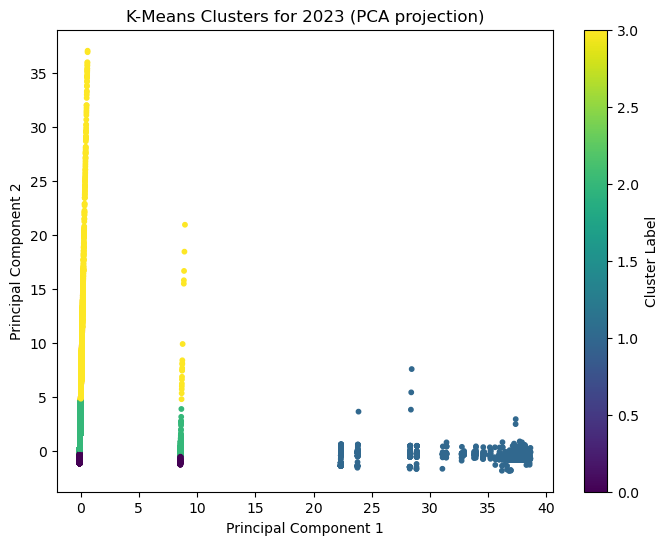

In [24]:
X_2023_pca = PCA(n_components=2).fit_transform(X_2023_norm)
plt.figure(figsize=(8,6))
plt.scatter(X_2023_pca[:,0], X_2023_pca[:,1], c=clusters_2023, cmap='viridis', s=10)
plt.title('K-Means Clusters for 2023 (PCA projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

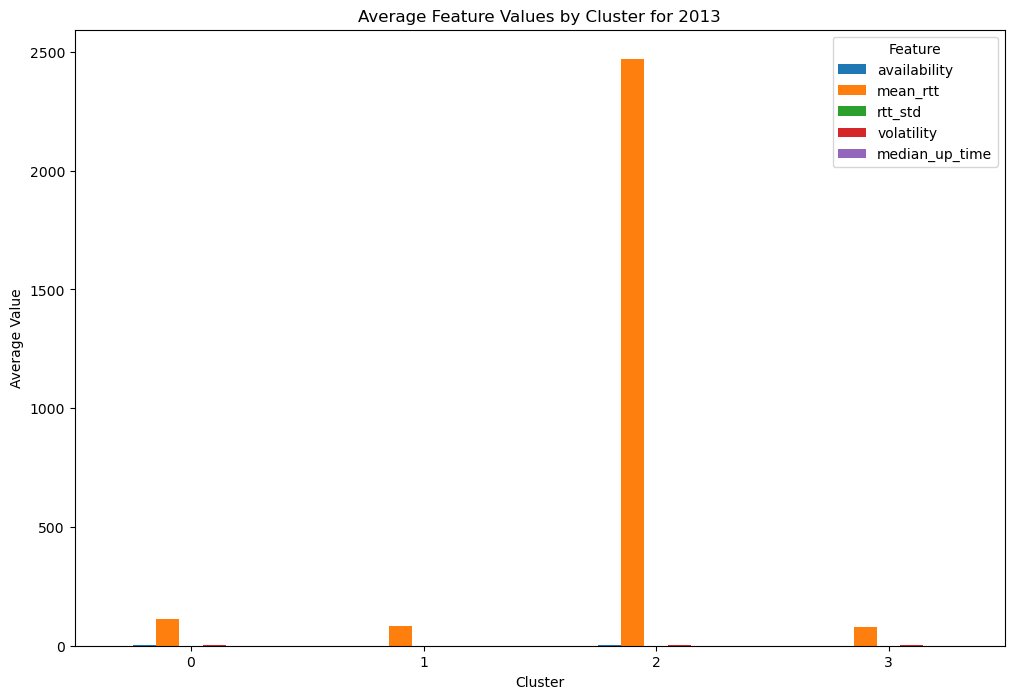

In [31]:
cluster_means_2013 = features_2013_clean.groupby('cluster')[feature_cols].mean()

cluster_means_2013.plot(kind='bar', figsize=(12, 8))
plt.title('Average Feature Values by Cluster for 2013')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(title='Feature')
plt.show()

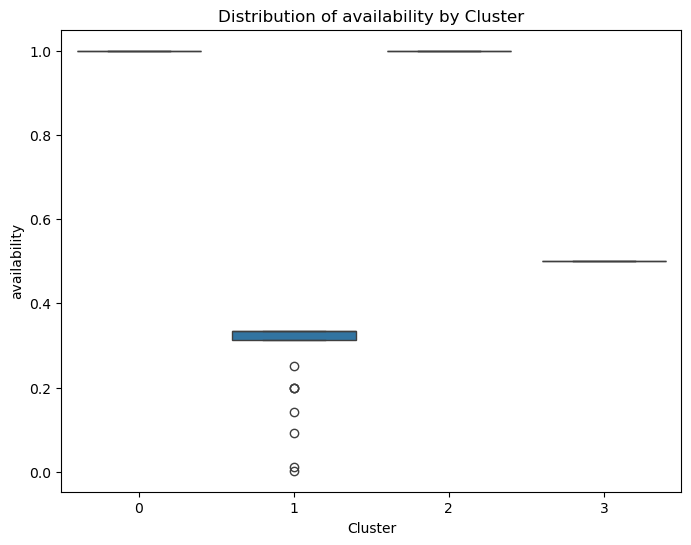

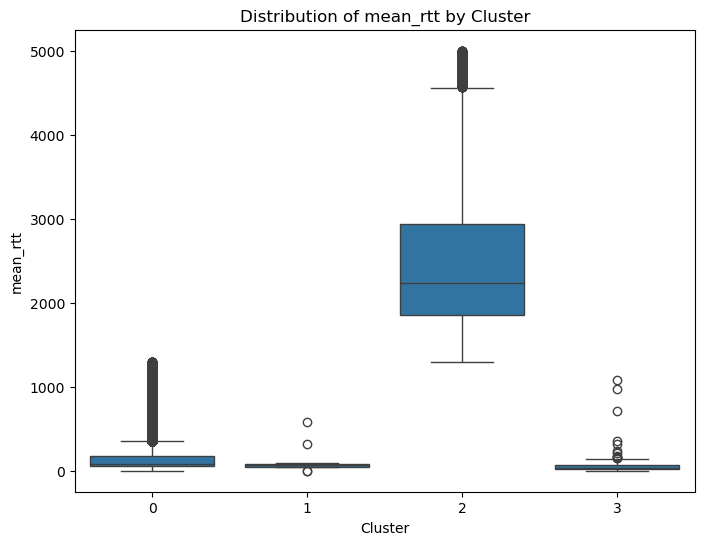

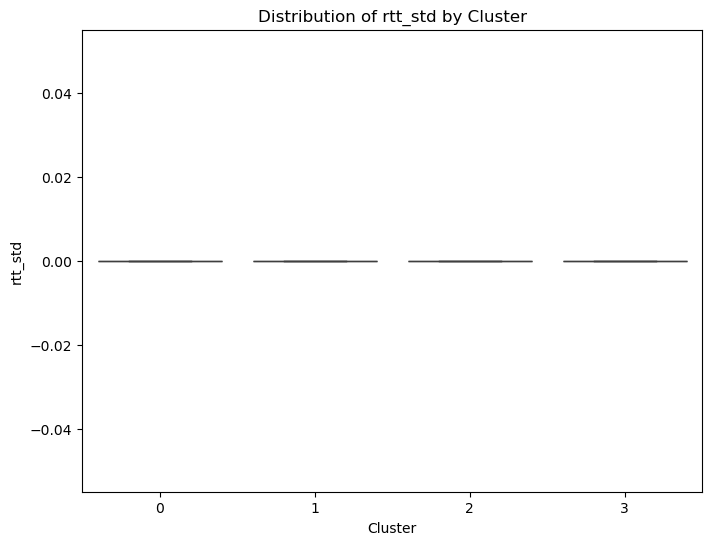

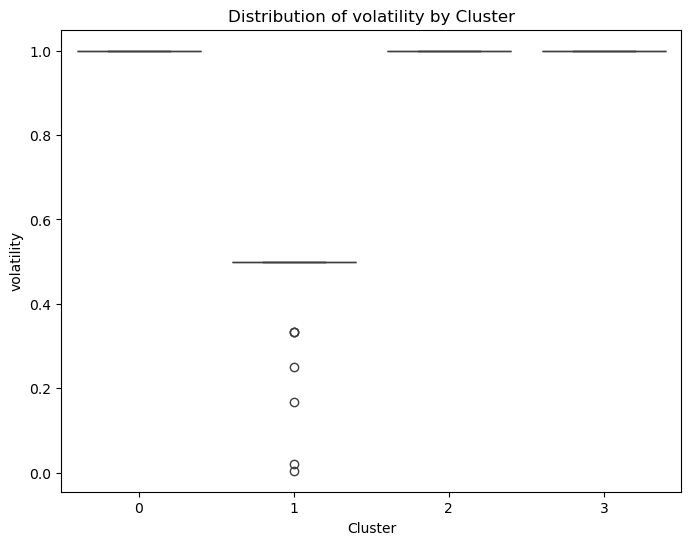

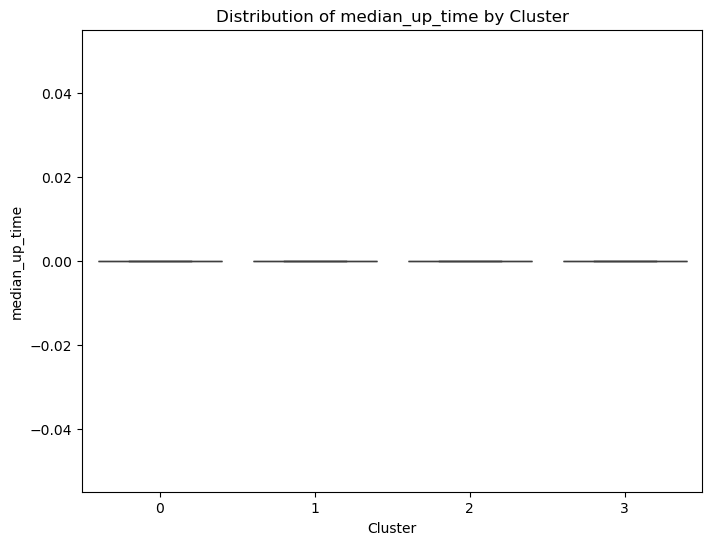

In [32]:
for feature in feature_cols:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='cluster', y=feature, data=features_2013_clean)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

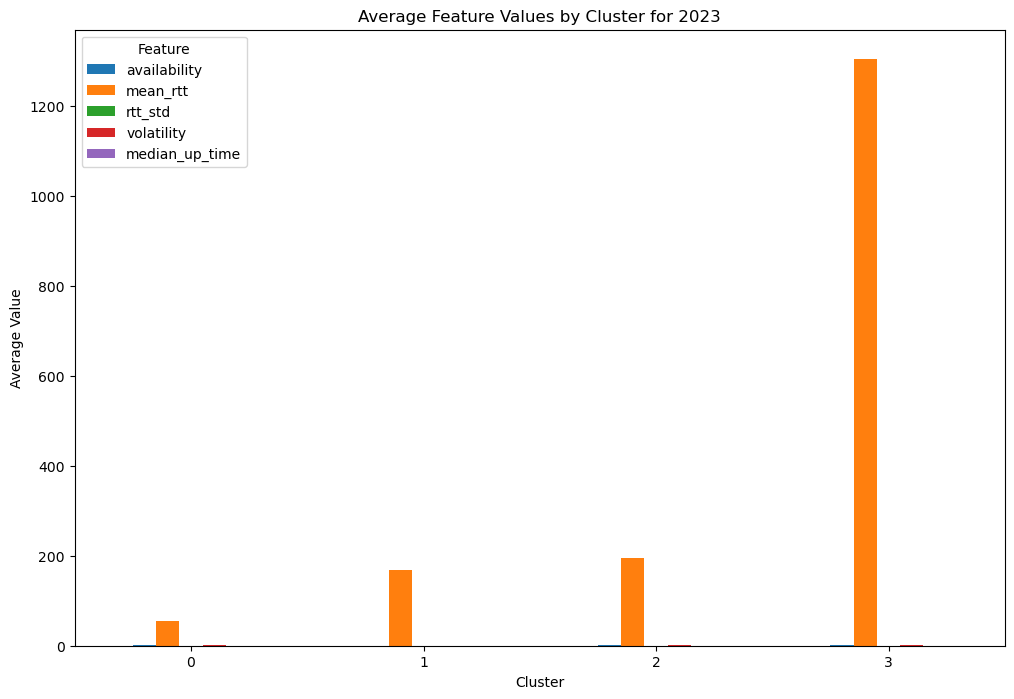

In [33]:
cluster_means_2023 = features_2023_clean.groupby('cluster')[feature_cols].mean()

cluster_means_2023.plot(kind='bar', figsize=(12, 8))
plt.title('Average Feature Values by Cluster for 2023')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(title='Feature')
plt.show()

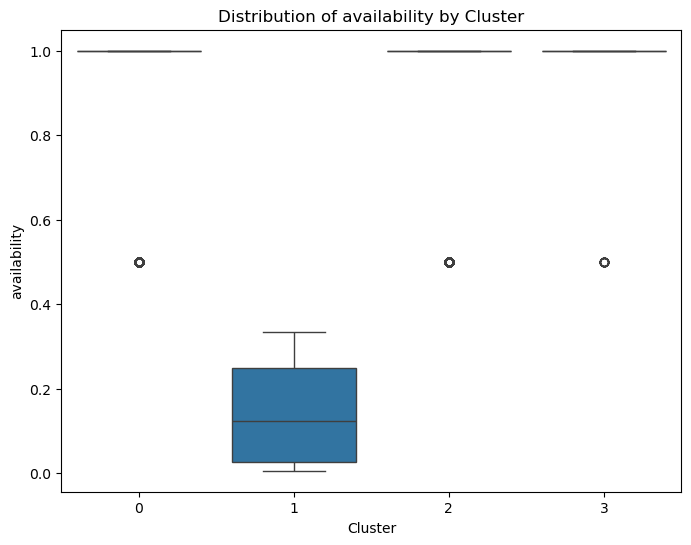

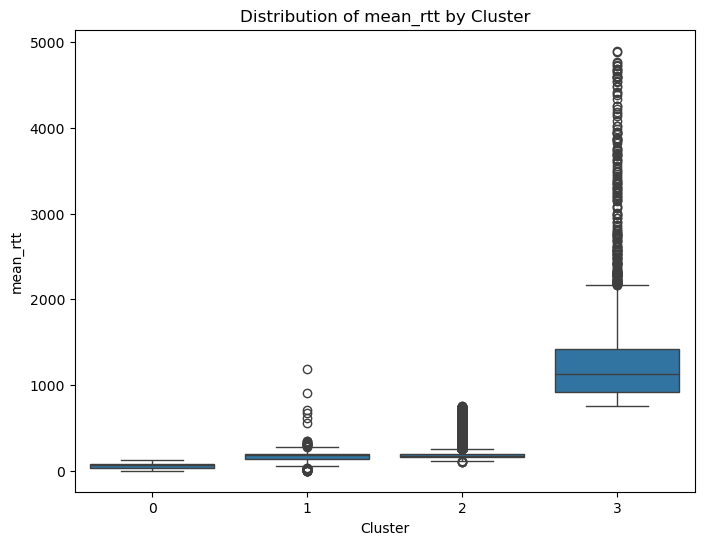

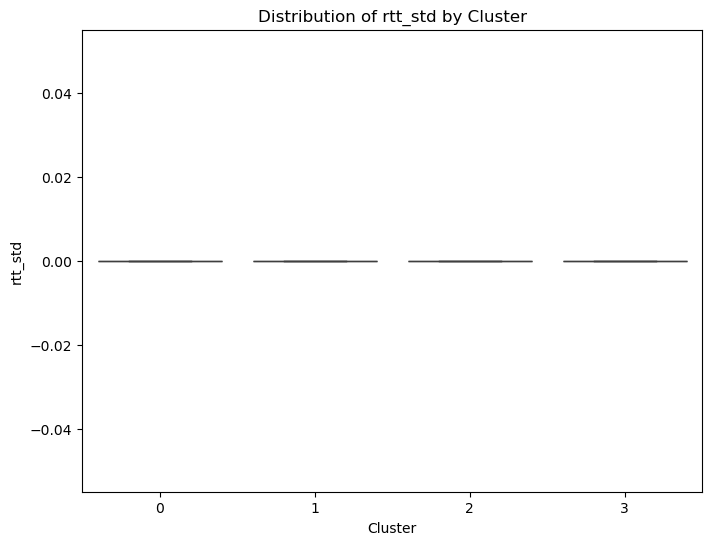

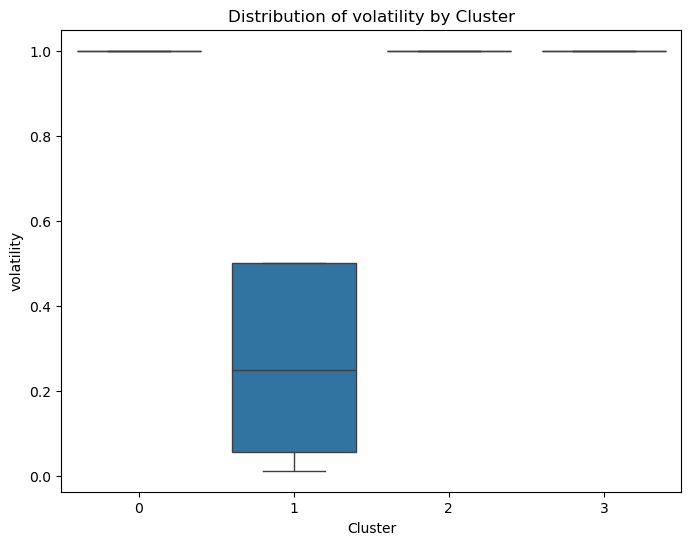

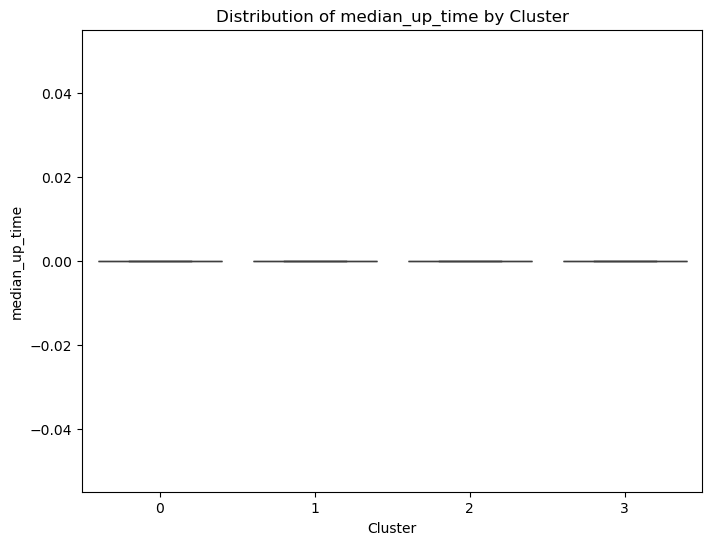

In [34]:
for feature in feature_cols:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='cluster', y=feature, data=features_2023_clean)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

In [35]:
print(features_2013_clean['cluster'].value_counts())

cluster_means_2013 = features_2013_clean.groupby('cluster')[feature_cols].mean()
print(cluster_means_2013)

cluster
0    599239
2     14060
3       113
1        32
Name: count, dtype: int64
         availability     mean_rtt  rtt_std  volatility  median_up_time
cluster                                                                
0            1.000000   112.030640      0.0    1.000000             0.0
1            0.284262    84.505000      0.0    0.435678             0.0
2            1.000000  2470.362093      0.0    1.000000             0.0
3            0.500000    78.147850      0.0    1.000000             0.0


In [36]:
active_2013 = features_2013_clean[features_2013_clean['availability'] > 0]

In [40]:
never_respond = features_2013[features_2013['availability'] == 0]
active_2013 = features_2013[features_2013['availability'] > 0]

In [41]:
active_2013

,availability,mean_rtt,rtt_std,volatility,median_up_time,n_probes,num_up_periods
probe_addr_2013,,,,,,,
128.0.104.1,1.0,199.670,0.0,1.0,0.0,1.0,1.0
128.0.104.2,1.0,207.189,0.0,1.0,0.0,1.0,1.0
128.0.104.3,1.0,186.440,0.0,1.0,0.0,1.0,1.0
128.0.105.1,1.0,198.454,0.0,1.0,0.0,1.0,1.0
128.0.105.10,1.0,189.108,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
128.98.26.217,1.0,144.411,0.0,1.0,0.0,1.0,1.0
128.98.26.225,1.0,151.583,0.0,1.0,0.0,1.0,1.0
128.98.26.240,1.0,152.700,0.0,1.0,0.0,1.0,1.0


In [42]:
feature_cols = ['availability', 'mean_rtt', 'rtt_std', 'volatility', 'median_up_time']
active_2013 = active_2013.dropna(subset=feature_cols).copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_active_2013 = scaler.fit_transform(active_2013[feature_cols])

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_active_2013 = kmeans.fit_predict(X_active_2013)

active_2013['cluster'] = clusters_active_2013
print(active_2013['cluster'].value_counts())

cluster_means = active_2013.groupby('cluster')[feature_cols].mean()
print(cluster_means)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster
0    599239
2     14060
3       113
1        32
Name: count, dtype: int64
         availability     mean_rtt  rtt_std  volatility  median_up_time
cluster                                                                
0            1.000000   112.030640      0.0    1.000000             0.0
1            0.284262    84.505000      0.0    0.435678             0.0
2            1.000000  2470.362093      0.0    1.000000             0.0
3            0.500000    78.147850      0.0    1.000000             0.0
